In [1]:
import matplotlib.pyplot as plt
import os
import torch
from typing import List
import pandas as pd
import gluonts
import numpy as np
import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing
import nnts.torch.models
import trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import nnts.pandas
import nnts
import nnts.experiments.plotting
import deepar

torch.set_printoptions(precision=8, sci_mode=False)
%load_ext autoreload
%autoreload 2

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
data_path = "data"
model_name = "deepar"
base_model_name = "base-lstm"
dataset_name = "tourism"
results_path = "ablation-results"
metadata_path = os.path.join(data_path, f"{base_model_name}-monash.json")
metadata = nnts.data.metadata.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = nnts.models.Hyperparams()
splitter = nnts.pandas.LastHorizonSplitter()

nnts.loggers.makedirs_if_not_exists(PATH)

In [3]:
#Gluonts defaults
params.batch_size = 32
params.batches_per_epoch = 50

In [4]:
gluonts.time_feature.lag.get_lags_for_frequency('M')

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]

In [5]:
next_month = df_orig["ds"] + pd.DateOffset(days=1)
df_orig["day_of_week"] = next_month.dt.day_of_week

next_month = df_orig["ds"]
df_orig["hour"] = next_month.dt.hour

next_month = df_orig["ds"] + pd.DateOffset(weeks=1)
df_orig["week"] = next_month.dt.isocalendar().week
df_orig["week"] = df_orig["week"].astype(np.float32)

next_month = df_orig["ds"] + pd.DateOffset(months=1)
df_orig["month"] = next_month.dt.month

In [6]:
# GluonTS uses the following code to generate the age covariate
# age = np.log10(2.0 + np.arange(length, dtype=self.dtype))
# length = the length of the time series. In GluonTS this length depends on the length of the training set and test set.
# but we do it once on the complete dataset.
# Also note that this doesn't align to the most recent time point, but to the first time point which 
# intuitively doesn't make sense. 
df_orig['unix_timestamp'] = np.log10(2.0 +df_orig.groupby('unique_id').cumcount())

In [7]:
# GlounTS uses the following code to generate the month covariate used in the tourism dataset
# the month value is extracted from the date column and then scaled to a value between -0.5 and 0.5
# here we do this is on the whole dataset in one go
max_min_scaler = nnts.torch.data.preprocessing.MaxMinScaler()
max_min_scaler.fit(df_orig, ["month", "week", "day_of_week", "hour"])
df_orig = max_min_scaler.transform(df_orig, ["month", "week", "day_of_week", "hour"])

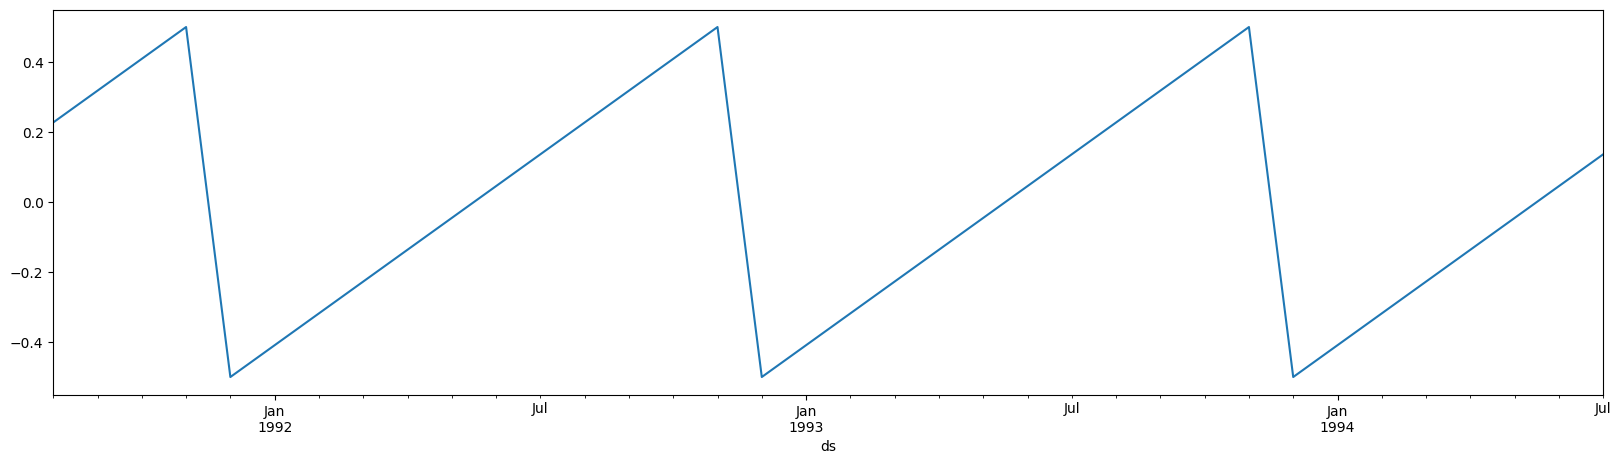

In [8]:
ax = df_orig[df_orig['unique_id'] == 'T1'].set_index('ds').tail(36)['month'].plot(figsize=(20, 5))
fig = ax.get_figure()

In [9]:
gluonts.time_feature.lag.get_lags_for_frequency("1H")

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 23,
 24,
 25,
 47,
 48,
 49,
 71,
 72,
 73,
 95,
 96,
 97,
 119,
 120,
 121,
 143,
 144,
 145,
 167,
 168,
 169,
 335,
 336,
 337,
 503,
 504,
 505,
 671,
 672,
 673,
 719,
 720,
 721]

In [10]:
from dataclasses import dataclass, field
lag_seq = gluonts.time_feature.lag.get_lags_for_frequency(metadata.freq)
lag_seq = [lag - 1 for lag in lag_seq if lag > 1]

In [11]:
@dataclass
class LagScenario(nnts.experiments.scenarios.BaseScenario):
    # covariates: int = field(init=False)
    dataset: str = ""
    lag_seq: List[int] = field(default_factory=list)
    scaled_covariates: List[str] = field(default_factory=list)

    def copy(self):
        return LagScenario(
            prediction_length=self.prediction_length,
            conts=self.conts.copy(),
            seed=self.seed,
            lag_seq=self.lag_seq.copy(),
            scaled_covariates=self.scaled_covariates.copy(),
        )

    def scaled_covariate_names(self):
        return "-".join(self.scaled_covariates)

    @property
    def name(self):
        return f"cov-{self.scaled_covariate_names()}-lags-{len(self.lag_seq)}-ds-{self.dataset}-seed-{self.seed}"

In [12]:

scaled_covariates = ["month", "unix_timestamp", nnts.torch.models.deepar.FEAT_SCALE]

scaled_covariate_selection_matrix = [
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
]

In [13]:
# Add the baseline scenarios
scenario_list: List[nnts.experiments.Scenario] = []

for seed in [42, 43, 44, 45, 46]:
    for row in scaled_covariate_selection_matrix:
        selected_combination = [
            covariate
            for covariate, select in zip(scaled_covariates, row)
            if select == 1
        ]
        scenario_list.append(
            LagScenario(
                metadata.prediction_length,
                conts=[cov for cov in selected_combination if cov != nnts.torch.models.deepar.FEAT_SCALE],
                scaled_covariates=selected_combination,
                lag_seq=lag_seq,
                seed=seed,
                dataset=metadata.dataset,
            )
        )

In [14]:
# DeepAR uses Teacher Forcing
params.training_method = nnts.models.hyperparams.TrainingMethod.TEACHER_FORCING

In [15]:
scenario = scenario_list[0]
nnts.torch.data.datasets.seed_everything(scenario.seed)
df = df_orig.copy()
context_length = metadata.context_length + max(scenario.lag_seq)
split_data = nnts.pandas.split_test_train_last_horizon(
    df, context_length, metadata.prediction_length
)
trn_dl, test_dl = nnts.data.create_trn_test_dataloaders(
    split_data,
    metadata,
    scenario,
    params,
    nnts.torch.data.preprocessing.TorchTimeseriesLagsDataLoaderFactory(),
)

In [16]:
batch = next(iter(test_dl))
batch['X'][0]

tensor([[3038.59179688],
        [3470.60937500],
        [6606.18359375],
        [6587.63671875],
        [4133.78271484],
        [2960.02441406],
        [1762.58496094],
        [2125.64013672],
        [1815.91503906],
        [1632.31494141],
        [2210.39501953],
        [2210.21508789],
        [3099.26928711],
        [3468.77783203],
        [6482.92529297],
        [6665.48486328],
        [4006.36181641],
        [2882.33496094],
        [1775.24987793],
        [2171.64990234],
        [1796.47497559],
        [1692.34985352],
        [1949.78515625],
        [2680.63012695],
        [2645.94995117],
        [3414.74291992],
        [5772.87695312],
        [6053.70410156],
        [3878.12841797],
        [2806.51489258],
        [1735.53820801],
        [2128.91992188],
        [1608.01416016],
        [1441.33007812],
        [2068.23510742],
        [2207.61010742],
        [2918.40991211],
        [3400.81787109],
        [6048.74218750],
        [6483.14013672],


In [17]:
batch = next(iter(test_dl))
context_prediction = batch['X'][0, -metadata.context_length - metadata.prediction_length:, 0]
context = context_prediction[:metadata.context_length]
context

tensor([2918.40991211, 3400.81787109, 6048.74218750, 6483.14013672,
        4063.50268555, 2900.22998047, 1907.09497070, 2338.51000977,
        1787.16503906, 1699.64514160, 1979.10522461, 2824.26000977,
        3076.50488281, 3402.58496094, 5985.83007812])

In [ ]:
[
    0.8615,
    0.6517,
    0.6105,
    0.4255,
    0.4747,
    0.6284,
    0.5123,
    1.7041,
    1.0080,
    0.7810,
    1.9137,
    1.0239,
    0.9149,
    1.9500,
    1.0245,
    0.8969,
    1.1929,
    0.0000,
    8.1279,
    -0.0455,
    2.1790,
]

In [18]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df = df_orig.copy()
    context_length = metadata.context_length + max(scenario.lag_seq)
    split_data = nnts.pandas.split_test_train_last_horizon(
        df, context_length, metadata.prediction_length
    )
    trn_dl, test_dl = nnts.data.create_trn_test_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.preprocessing.TorchTimeseriesLagsDataLoaderFactory(),
    )
    logger = nnts.loggers.LocalFileRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = nnts.torch.models.DeepAR(
        nnts.torch.models.LinearModel,
        params,
        nnts.torch.data.preprocessing.masked_mean_abs_scaling,
        1,
        lag_seq=lag_seq,
        scaled_features=scenario.scaled_covariates,
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        os.path.join(PATH, f"{scenario.name}.pt")
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, trn_dl, metadata
    )
    logger.log(test_metrics)
    print(test_metrics)
    logger.finish()

DeepAR(
  (decoder): UnrolledLSTMDecoder(
    (rnn): LSTM(17, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Artifact saved to ablation-results/deepar/tourism/cov-feat_scale-lags-15-ds-tourism-seed-42.pt
Train Loss: 80.99246978759766
Artifact saved to ablation-results/deepar/tourism/cov-feat_scale-lags-15-ds-tourism-seed-42.pt
Train Loss: 54.22316360473633
Artifact saved to ablation-results/deepar/tourism/cov-feat_scale-lags-15-ds-tourism-seed-42.pt
Train Loss: 52.12800979614258
Artifact saved to ablation-results/deepar/tourism/cov-feat_scale-lags-15-ds-tourism-seed-42.pt
Train Loss: 44.26981735229492
Artifact saved to ablation-results/deepar/tourism/cov-feat_scale-lags-15-ds-tourism-seed-42.pt
Train Loss: 42.70716094970703
Artifact saved to ablation-results/deepar/tourism/co

In [ ]:
gluon_y_hat = torch.tensor([[196372.62, 165181.3 , 165461.52, 112738.36, 101019.29, 119415.25,
        99374.21, 100394.86, 120971.04, 135340.64, 140176.89, 189092.1 ,
       216439.94, 180999.  , 181581.2 , 134117.25, 113978.02, 128168.54,
       104687.95, 109475.93, 133661.48, 144187.88, 151112.25, 207645.45]])

median_gluon_y_hat = torch.tensor(
    [[194658.28,
                166323.62,
                165344.86,
                114376.87,
                100225.305,
                120307.27,
                99509.57,
                101183.58,
                122892.54,
                135910.06,
                141746.81,
                188034.66,
                215407.0,
                178931.4,
                177086.23,
                132594.23,
                111427.17,
                128356.164,
                103692.95,
                108119.62,
                134489.94,
                142435.2,
                148844.8,
                208224.39,
            ]
    ]
)

In [ ]:
test_metrics

In [ ]:
csv_aggregator = nnts.pandas.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [ ]:
results = pd.read_csv(f"{PATH}/results.csv")
results

In [ ]:
df_list = deepar.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = nnts.experiments.plotting.plot(df_list, scenario.prediction_length)